In [ ]:
import extract_paths
import matplotlib.pyplot as pyp

paths = extract_paths.load_paths('g21/matches/')

In [ ]:
from extract_paths import ind
import numpy as np

print('Number of paths:')
print(len(paths))
for i in range(len(paths)):
    print(i)
    #computes some statistics of the paths
    paths[i][ind('high_b_lyap')] = len( [x for x in paths[i][ind('b_lyap')] if x == 0] )
    paths[i][ind('high_d_lyap')] = len( [x for x in paths[i][ind('d_lyap')] if x == 0] )
    pathlen = paths[i][2] - paths[i][1]
    #if( (int)(0.05*pathlen) > 0 ):
    #    paths[i][ind('avg_p_firstpts')] = np.average( ( np.array(paths[i][ind('death')]) - np.array(paths[i][ind('birth')]) )[0:(int)(0.05*pathlen)] )
    #if( (int)(0.95*pathlen) < pathlen-1 ):
    #    paths[i][ind('avg_p_lastpts')] = np.average( ( np.array(paths[i][ind('death')]) - np.array(paths[i][ind('birth')]) )[(int)(0.95*pathlen):pathlen-1] )
    paths[i][ind('max_p')] = np.max( np.array(paths[i][ind('death')]) - np.array(paths[i][ind('birth')]) )
    #paths[i][ind('avg_b')] = np.average( np.array(paths[i][ind('birth')]) )


In [ ]:
#plots all paths satisfying certain characteristic

from extract_paths import ind
import numpy as np
import math

def notnoisy(dim, minbirth, mindeath, maxbirth, maxdeath):
    if(dim == 1):
        return maxbirth > 50 and mindeath < 200
    if(dim == 0):
        return minbirth < 200 and maxdeath > 50

def computesat(death_b, birth_b, death_e, birth_e, fldist, maxbirth, mindeath):
    return ( (death_b-birth_b) < 30 or (death_e - birth_e) < 30 ) and fldist > math.sqrt(300) and notnoisy(maxbirth, mindeath)

def brettscondition(dim, pathlen, births, deaths):
    N = len(births)
    MGV = 127
    UCV = 174
    LCV = 80
    DELTA = 10
    if(dim == 1): #light plume
        for i in range(N):
            if(births[i] <= MGV and deaths[i] <= UCV and (deaths[i] - births[i] >= DELTA and pathlen > 2)):
                return 1
    if(dim == 0): #dark plume
        for i in range(N):
            if(births[i] >= MGV and deaths[i] >= LCV and ( births[i] - deaths[i] >= DELTA and pathlen > 2)):
                return 1
    return 0    

count = 0
countfilteredpaths = 0
counttotalpaths = 0
countfilteredandinteresting = 0

LEN = 8998

framecoverall = np.zeros(LEN, dtype = float)
framecover = np.zeros(LEN, dtype = float)
framecoverminnoise = np.zeros(LEN, dtype = float)
framecoverfull = np.zeros(LEN, dtype = float)

for i in range(len(paths)):
    begin = paths[i][1]
    end = paths[i][2]
    print(begin)
    print(end)
    pathlen = paths[i][2] - paths[i][1]
    fldist = (paths[i][ind('birth')][0]-paths[i][ind('birth')][-1])*(paths[i][ind('birth')][0]-paths[i][ind('birth')][-1]) + (paths[i][ind('death')][0]-paths[i][ind('death')][-1])*(paths[i][ind('death')][0]-paths[i][ind('death')][-1])    
    fldist = math.sqrt(fldist)
    minbirth = np.amin(paths[i][ind('birth')])
    maxbirth = np.amax(paths[i][ind('birth')])
    mindeath = np.amin(paths[i][ind('death')])
    maxdeath = np.amax(paths[i][ind('death')])
    
    #sat = computesat(paths[i][ind('death')][0], paths[i][ind('birth')][0], paths[i][ind('death')][-1], paths[i][ind('birth')][-1], fldist, maxbirth, mindeath)
    brettc = brettscondition(paths[i][ind('dim')], pathlen, paths[i][ind('birth')], paths[i][ind('death')])
    
    if( brettc ):
        framecoverall[ begin : end ] += 1
        count += 1
    if( brettc  and paths[i][ind('high_b_lyap')] > 4 ):
        framecover[ begin : end ] += 1        
    framecoverfull[begin : end] += 1
    if( notnoisy(paths[i][3], minbirth, mindeath, maxbirth, maxdeath)):
        framecoverminnoise[begin : end] += 1

print(count)

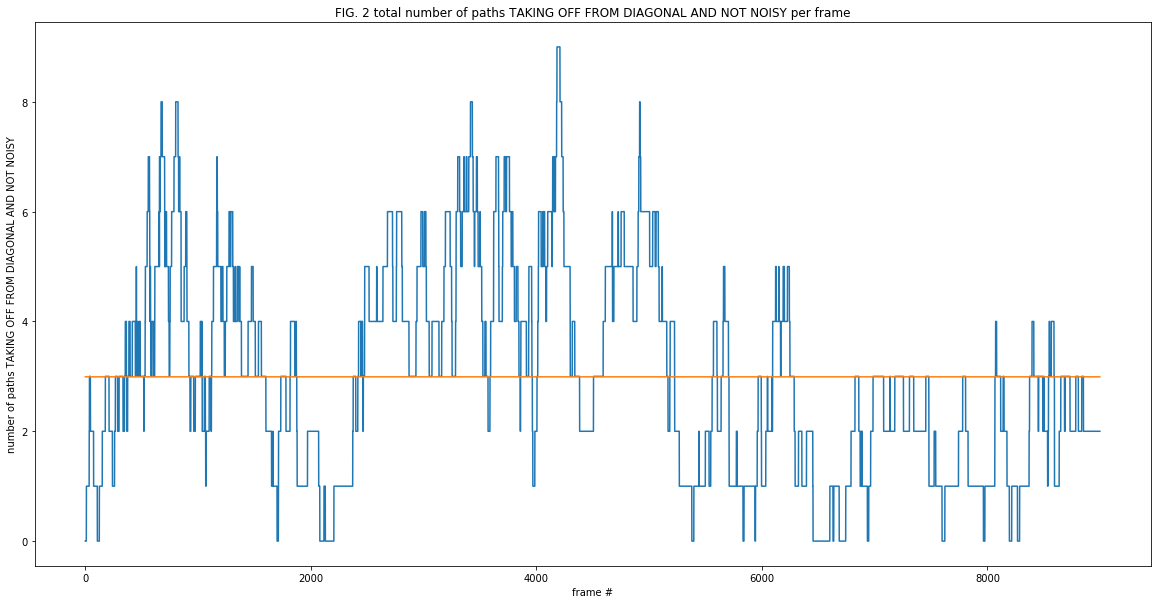

In [5]:
avg = np.zeros( LEN, dtype=float)
avg.fill(np.average(framecoverall))
pyp.figure( figsize=(20,10) )
pyp.title('FIG. 2 total number of paths TAKING OFF FROM DIAGONAL AND NOT NOISY per frame')
pyp.xlabel('frame #')
pyp.ylabel('number of paths TAKING OFF FROM DIAGONAL AND NOT NOISY')
pyp.plot(range(LEN), framecoverall, range(LEN), avg)
pyp.show()

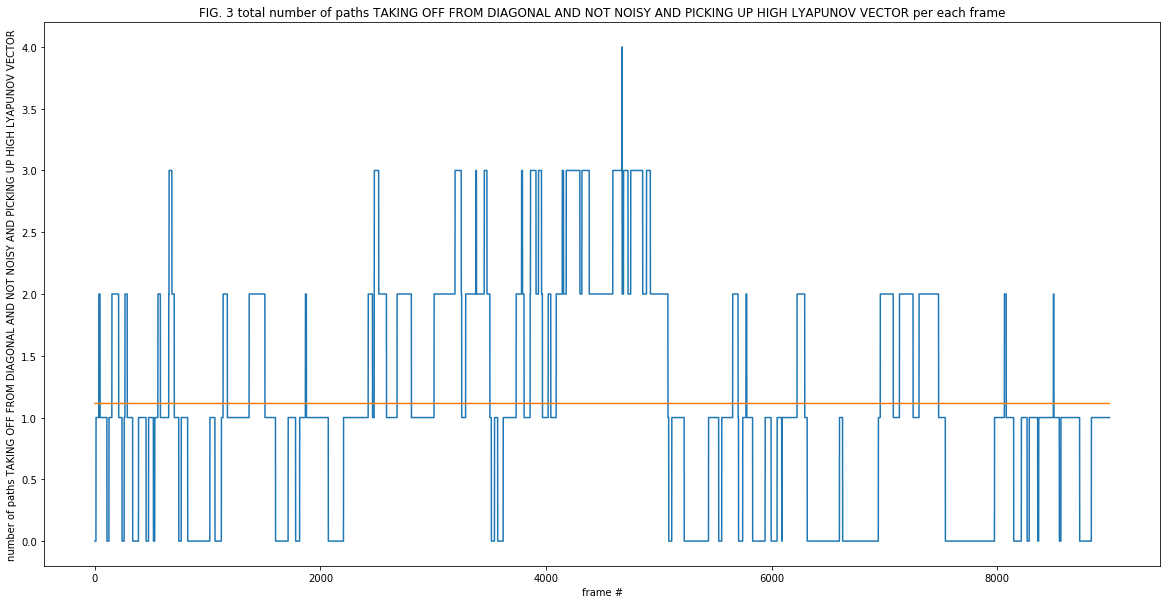

In [6]:
avg = np.zeros( LEN, dtype=float)
avg.fill(np.average(framecover))
pyp.figure( figsize=(20,10) )
pyp.title('FIG. 3 total number of paths TAKING OFF FROM DIAGONAL AND NOT NOISY AND PICKING UP HIGH LYAPUNOV VECTOR per each frame')
pyp.xlabel('frame #')
pyp.ylabel('number of paths TAKING OFF FROM DIAGONAL AND NOT NOISY AND PICKING UP HIGH LYAPUNOV VECTOR')
pyp.plot(range(LEN), framecover, range(LEN), avg)
pyp.show()       

In [7]:
print('Probability that at an instant of time there is at least one \'arch\' picking up high Lyapunov vector')
print( (str)(len( [x for x in framecover if x > 0] ) / len( framecover )) ) 

Probability that at an instant of time there is at least one 'arch' picking up high Lyapunov vector
0.7224938875305623


In [8]:
#computes paths minimal distances from Lyapunov vector blobs
import numpy as np
import skimage as ski
from skimage import io
from extract_paths import ind

def notnoisy(maxbirth, mindeath):
    return maxbirth > 50 and mindeath < 200

spotsdir = 'g21per_spots2/'

pathmindists = np.zeros((len(paths),), dtype = float)
closepts = np.zeros((len(paths),), dtype = float)

for i in range(len(paths)):
    begin = paths[i][1]
    end = paths[i][2]
    pathlen = paths[i][2] - paths[i][1]
    fldist = (paths[i][ind('birth')][0]-paths[i][ind('birth')][-1])*(paths[i][ind('birth')][0]-paths[i][ind('birth')][-1]) + (paths[i][ind('death')][0]-paths[i][ind('death')][-1])*(paths[i][ind('death')][0]-paths[i][ind('death')][-1])    
    fldist = math.sqrt(fldist)
    maxbirth = np.amax(paths[i][ind('birth')])
    mindeath = np.amin(paths[i][ind('death')])

    #sat = computesat(paths[i][ind('death')][0], paths[i][ind('birth')][0], paths[i][ind('death')][-1], paths[i][ind('birth')][-1], fldist, maxbirth, mindeath)
    bretc = brettscondition(paths[i][ind('dim')], pathlen, paths[i][ind('birth')], paths[i][ind('death')])
    if( bretc ):           
        dists = []
        for j in range(pathlen):
            curframe = paths[i][1] + j
            if(curframe <= 9000):
                img = io.imread(spotsdir + '%05d.bmp'%curframe)
                mask = (img == 255)
                indices = np.nonzero(mask)
                nrindices = len(indices[0])

                #JC changed this code such that it works on H1 sub/super
                #compute mindists (currently distance of first point on the path)
                #if(paths[i][ind('dim')] == 0): #plume location is (b_x,b_y)
                #dists.append( np.min(np.sqrt( (np.full((nrindices,), paths[i][ind('b_x')][j]) - indices[1])*(np.full((nrindices,), paths[i][ind('b_x')][j]) - indices[1]) + (np.full((nrindices,), paths[i][ind('b_y')][j]) - indices[0])*( np.full((nrindices,), paths[i][ind('b_y')][j]) - indices[0] ) ) ) )
                #if(paths[i][ind('dim')] == 1): #plume location is (d_x,d_y)
                dists.append( np.min(np.sqrt( (np.full((nrindices,), paths[i][ind('d_x')][j]) - indices[1])*(np.full((nrindices,), paths[i][ind('d_x')][j]) - indices[1]) + (np.full((nrindices,), paths[i][ind('d_y')][j]) - indices[0])*( np.full((nrindices,), paths[i][ind('d_y')][j]) - indices[0] ) ) ) )                          
            if(len(dists) > 0):
                closepts[i] = np.sum(np.asarray(dists) < 10)                
                pathmindists[i] = np.min(np.array(dists))        
        
        paths[i].append(pathmindists[i])
        paths[i].append(closepts[i])

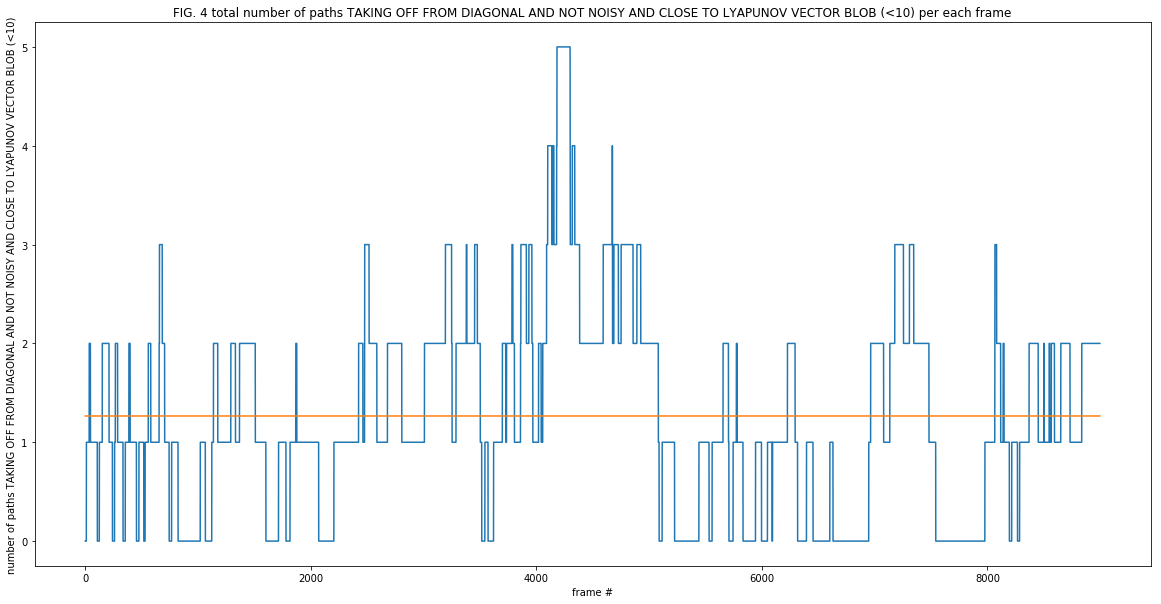

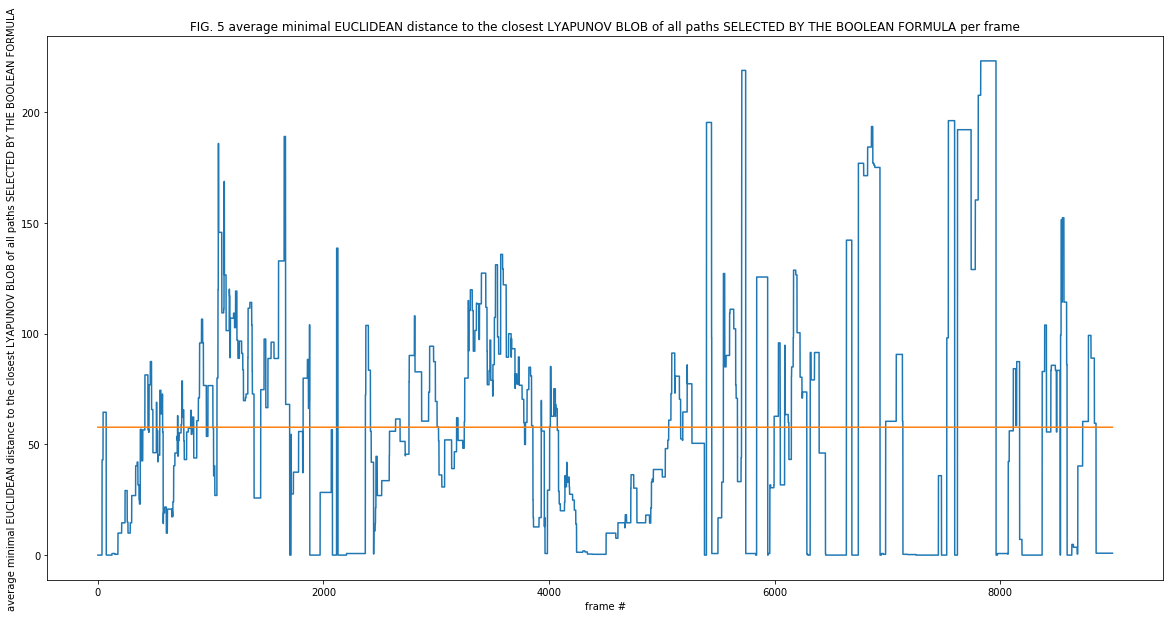

In [9]:
import math

LEN = 8998
framecoverclose = np.zeros(LEN, dtype = float)
framesummindist = np.zeros(LEN, dtype = float)
frametotalsat = np.zeros(LEN, dtype = float)

for i in range(len(paths)):
    begin = paths[i][1]
    end = paths[i][2]
    pathlen = paths[i][2] - paths[i][1]
    fldistsq = (paths[i][ind('birth')][0]-paths[i][ind('birth')][-1])*(paths[i][ind('birth')][0]-paths[i][ind('birth')][-1]) + (paths[i][ind('death')][0]-paths[i][ind('death')][-1])*(paths[i][ind('death')][0]-paths[i][ind('death')][-1])    
    fldist = math.sqrt(fldistsq)
    maxbirth = np.amax(paths[i][ind('birth')])
    mindeath = np.amin(paths[i][ind('death')])    
    #sat = computesat(paths[i][ind('death')][0], paths[i][ind('birth')][0], paths[i][ind('death')][-1], paths[i][ind('birth')][-1], fldist, maxbirth, mindeath)    
    sat = brettscondition(paths[i][ind('dim')], pathlen, paths[i][ind('birth')], paths[i][ind('death')])    
    if( sat and len(paths[i]) > 18):        
        framesummindist[ begin : end ] += paths[i][18]
        frametotalsat[ begin : end ] += 1
    if( sat  and len(paths[i]) > 19 and paths[i][19] > 5 ):
        framecoverclose[ begin : end ] += 1

avg = np.zeros( LEN, dtype=float)
avg.fill(np.average(framecoverclose))
pyp.figure( figsize=(20,10) )
pyp.title('FIG. 4 total number of paths TAKING OFF FROM DIAGONAL AND NOT NOISY AND CLOSE TO LYAPUNOV VECTOR BLOB (<10) per each frame')
pyp.xlabel('frame #')
pyp.ylabel('number of paths TAKING OFF FROM DIAGONAL AND NOT NOISY AND CLOSE TO LYAPUNOV VECTOR BLOB (<10)')
pyp.plot(range(LEN), framecoverclose, range(LEN), avg)
pyp.show()

frametotalsat2 = [(x if x>0 else 1) for x in frametotalsat]

avg = np.zeros( LEN, dtype=float)
avg.fill(np.average(framesummindist / frametotalsat2))
pyp.figure( figsize=(20,10) )
pyp.title('FIG. 5 average minimal EUCLIDEAN distance to the closest LYAPUNOV BLOB of all paths SELECTED BY THE BOOLEAN FORMULA per frame')
pyp.xlabel('frame #')
pyp.ylabel('average minimal EUCLIDEAN distance to the closest LYAPUNOV BLOB of all paths SELECTED BY THE BOOLEAN FORMULA')
pyp.plot(range(LEN), framesummindist / frametotalsat2, range(LEN), avg)
pyp.show()


In [10]:
print('Probability that at an instant of time there is at least one \'arch\' CLOSE TO high Lyapunov vector BLOB')
print( (str)(len( [x for x in framecoverclose if x > 0] ) / len( framecoverclose )) ) 

Probability that at an instant of time there is at least one 'arch' CLOSE TO high Lyapunov vector BLOB
0.7518337408312958


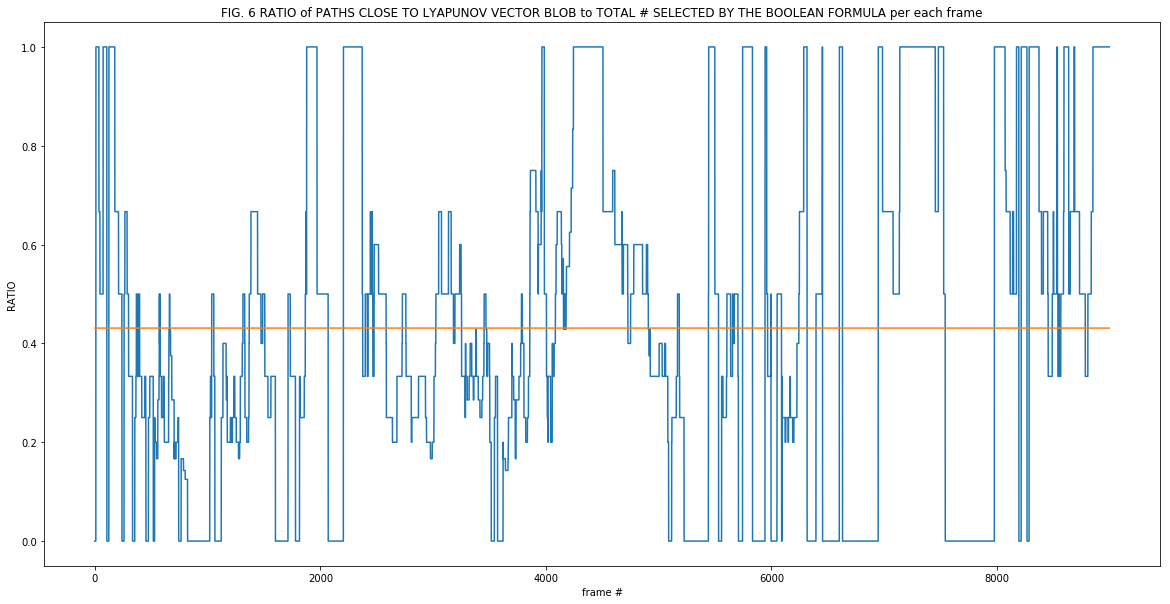

In [11]:
ratio = framecoverclose / np.array([x if x>0 else 1 for x in framecoverall])
avg = np.zeros( LEN, dtype=float)
avg.fill(np.average(ratio))
pyp.figure( figsize=(20,10) )
pyp.title('FIG. 6 RATIO of PATHS CLOSE TO LYAPUNOV VECTOR BLOB to TOTAL # SELECTED BY THE BOOLEAN FORMULA per each frame')
pyp.xlabel('frame #')
pyp.ylabel('RATIO')
pyp.plot(range(LEN), ratio, range(LEN), avg)
pyp.show()

In [12]:
print('AVERAGE RATIO of PATHS PICKING UP HIGH LYAPUNOV VECTOR to SELECTED BY THE BOOLEAN FORMULA per each frame')
print(np.average(ratio))

AVERAGE RATIO of PATHS PICKING UP HIGH LYAPUNOV VECTOR to SELECTED BY THE BOOLEAN FORMULA per each frame
0.431033483631


In [13]:
print('RATIO OF "FALSE POSITIVES"')
print(1- np.average(ratio))

RATIO OF "FALSE POSITIVES"
0.568966516369


OUTPUT OF ALL PATHS SELECTED BY THE BOOLEAN FORMULA 


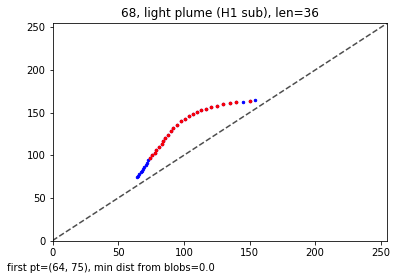

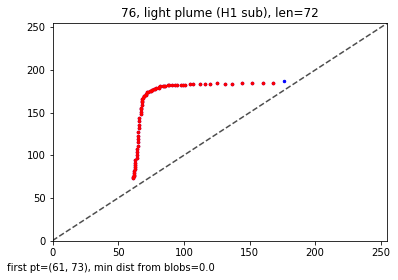

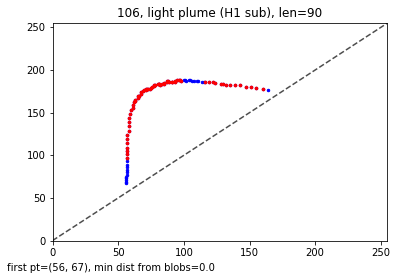

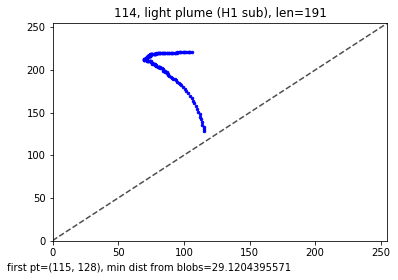

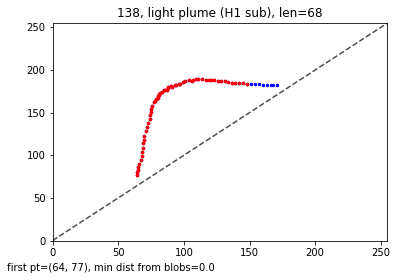

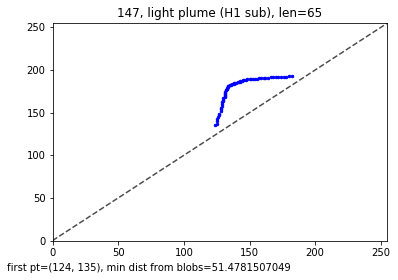

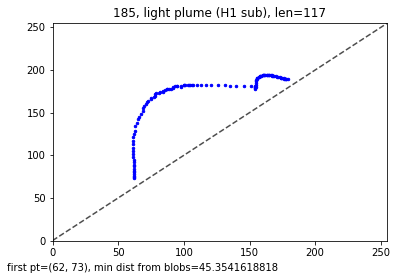

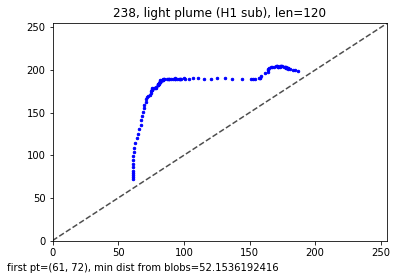

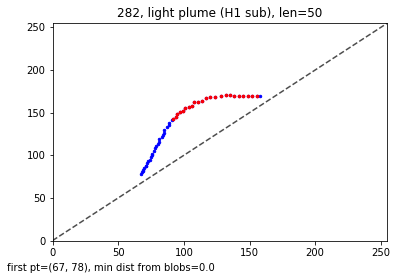

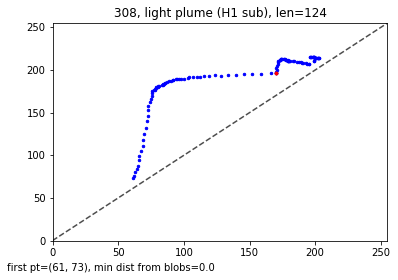

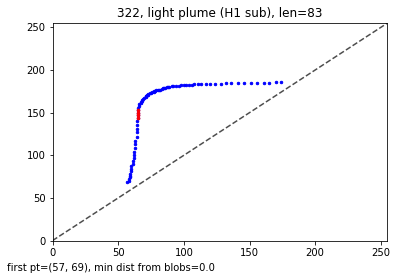

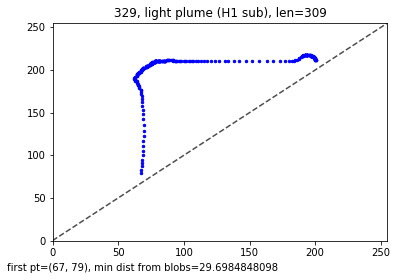

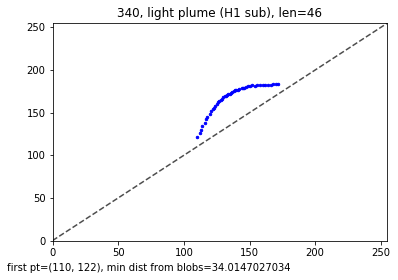

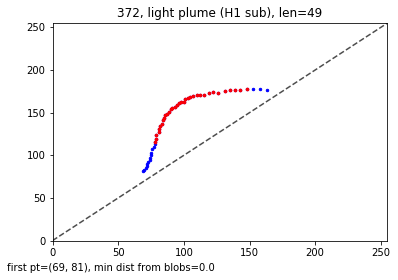

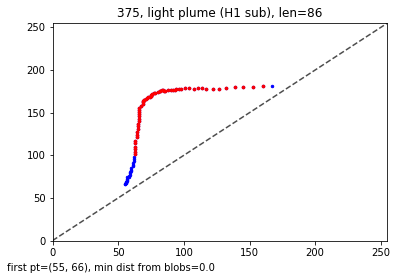

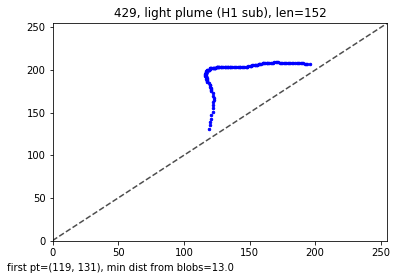

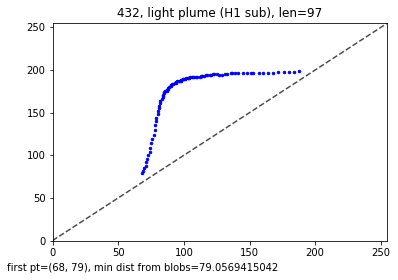

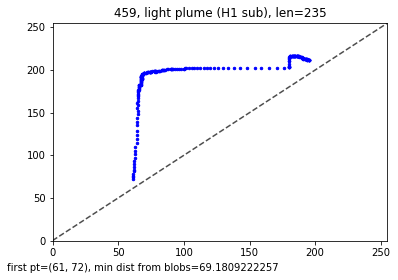

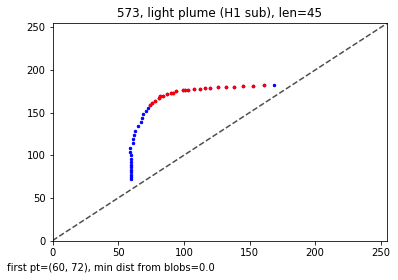

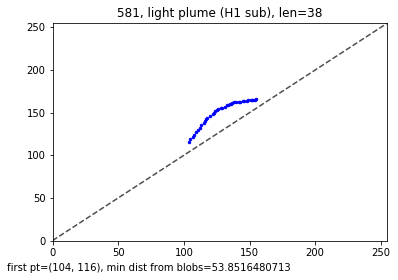

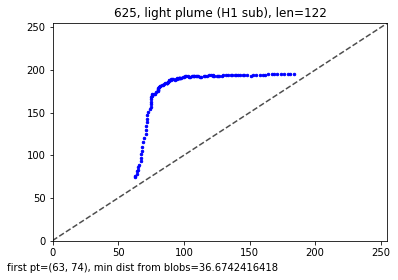

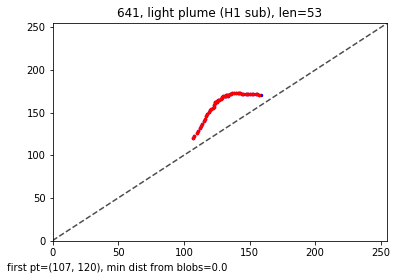

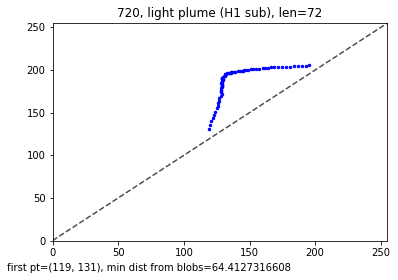

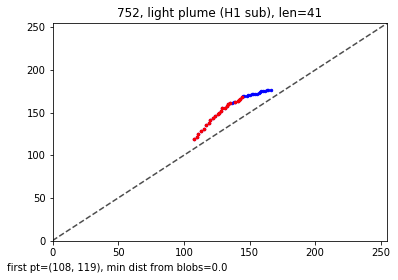

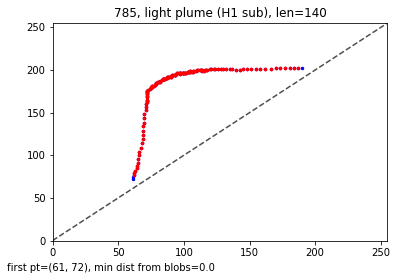

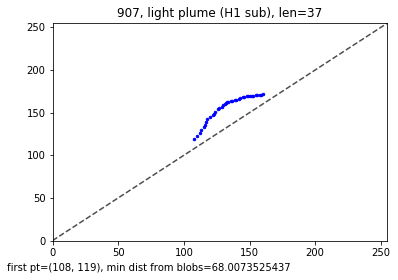

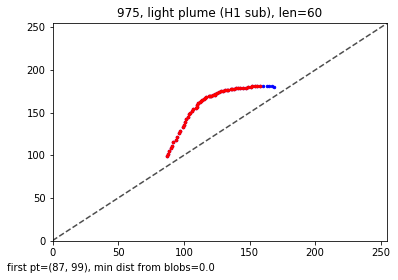

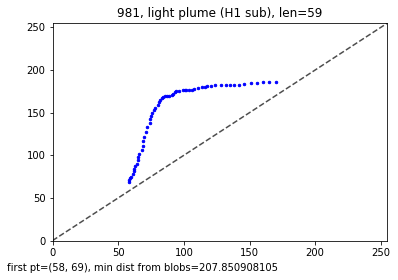

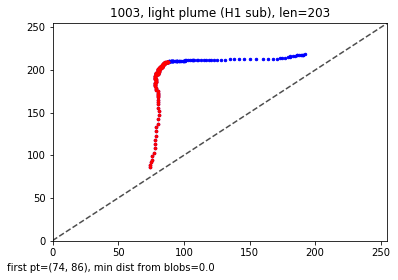

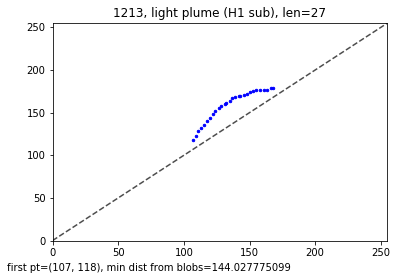

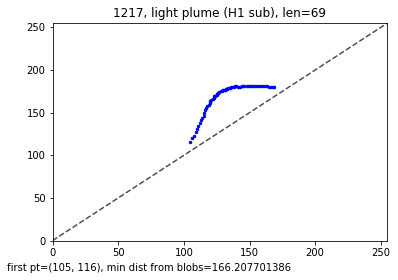

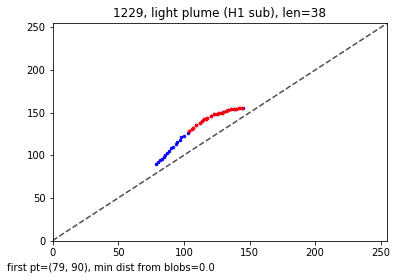

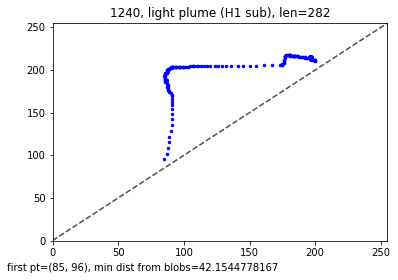

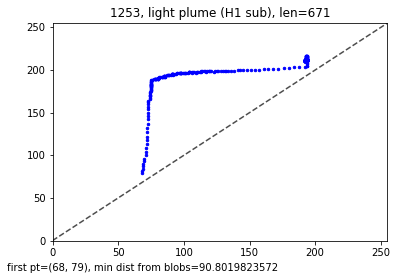

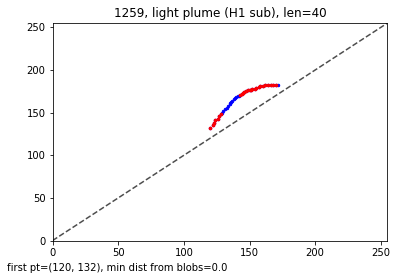

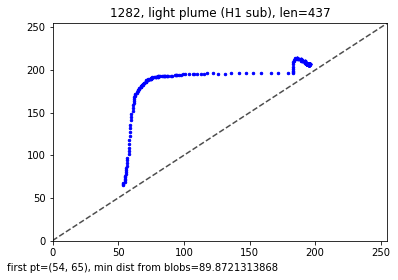

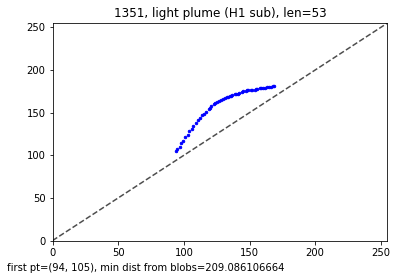

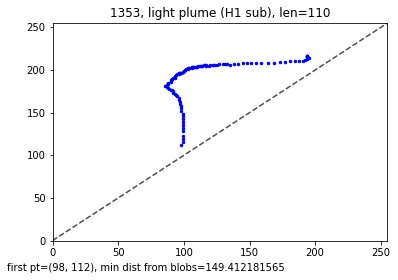

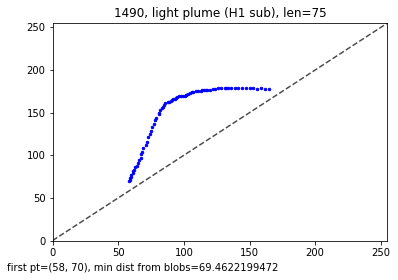

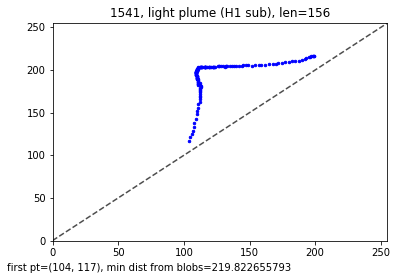

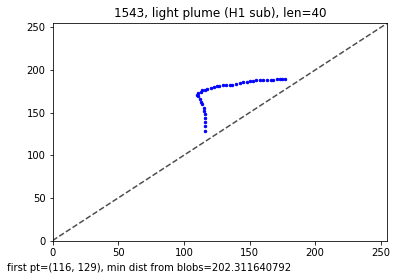

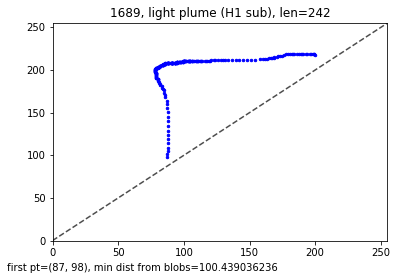

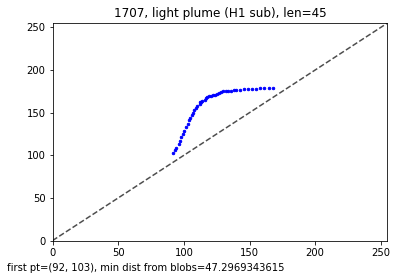

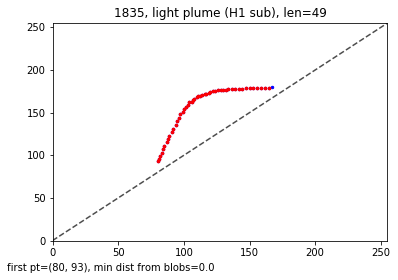

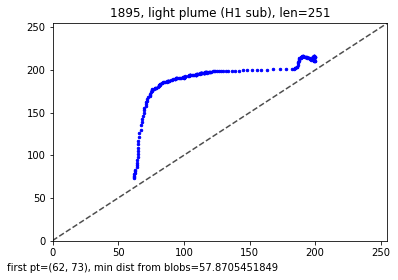

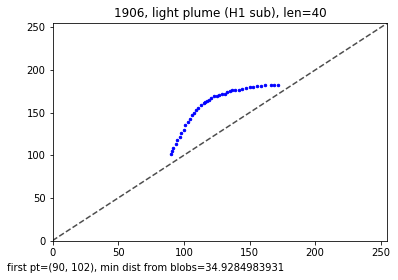

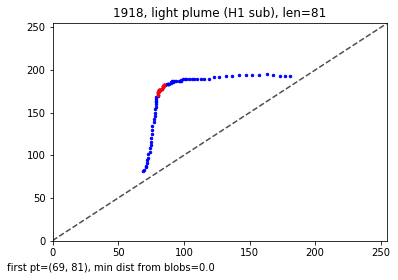

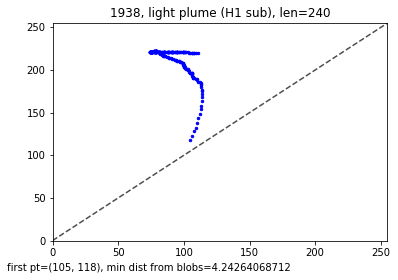

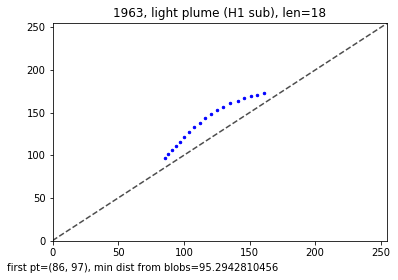

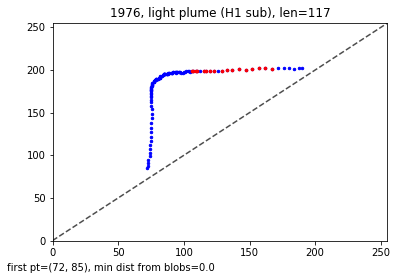

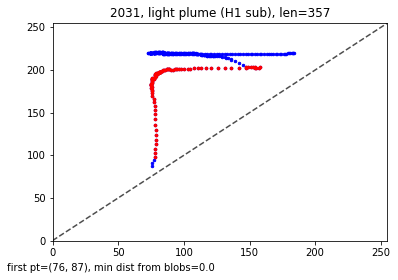

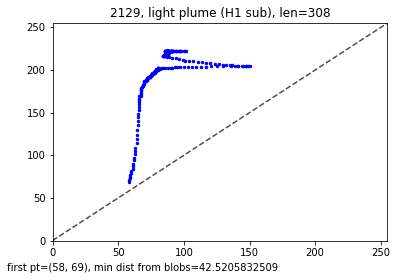

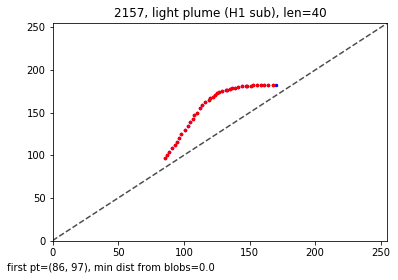

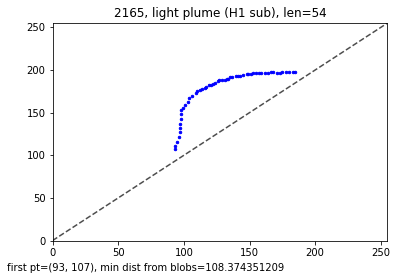

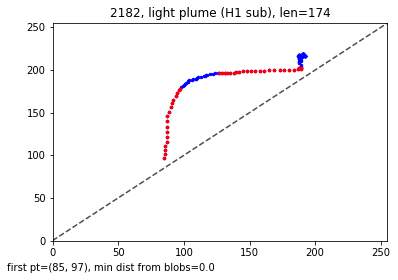

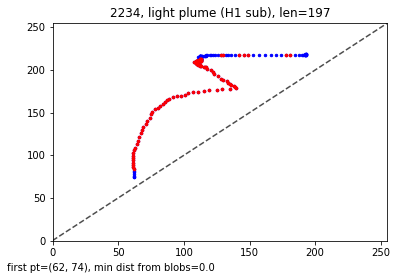

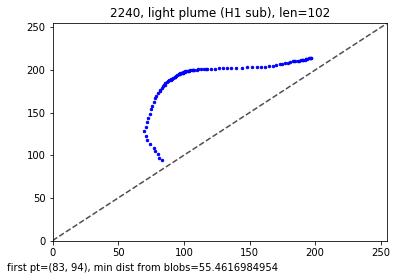

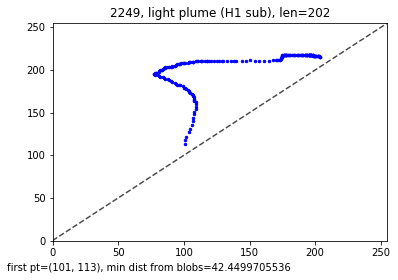

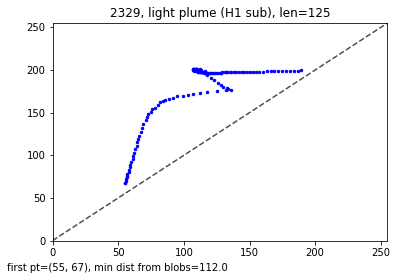

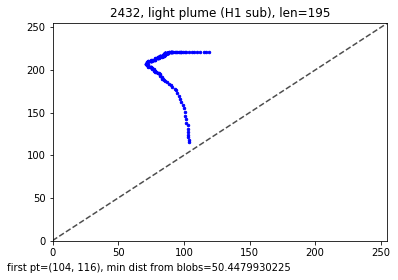

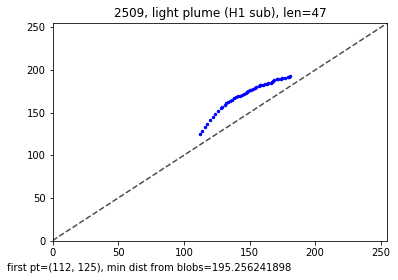

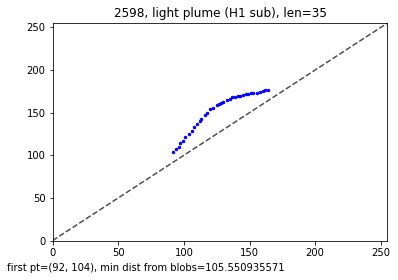

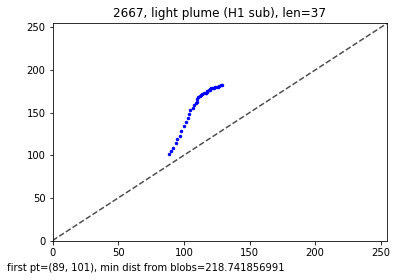

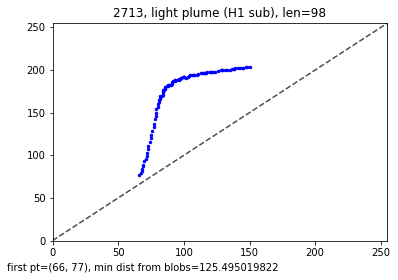

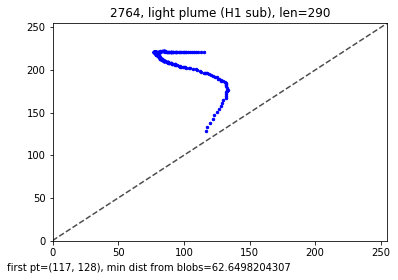

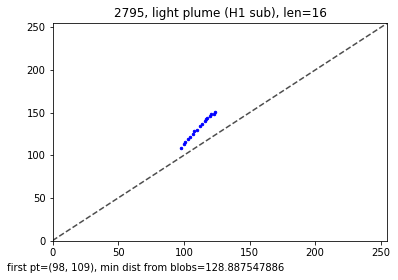

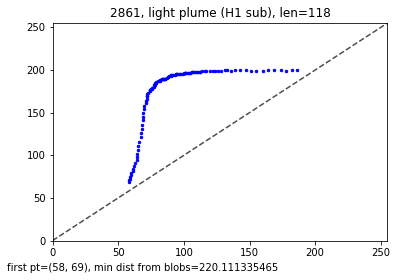

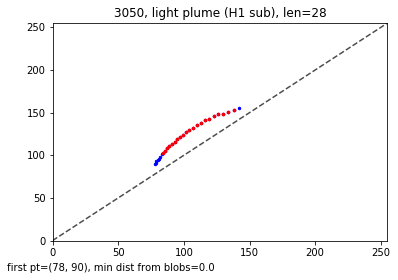

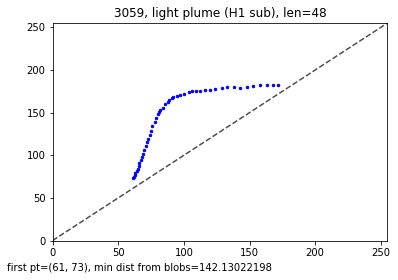

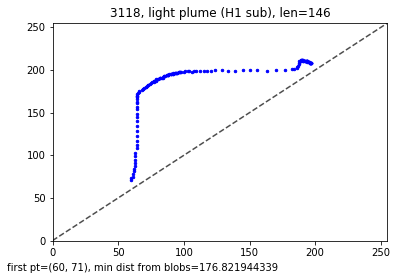

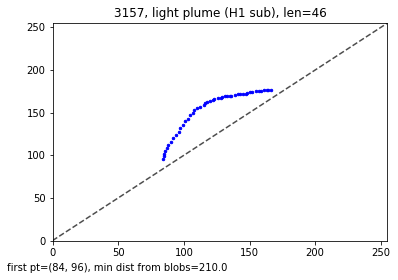

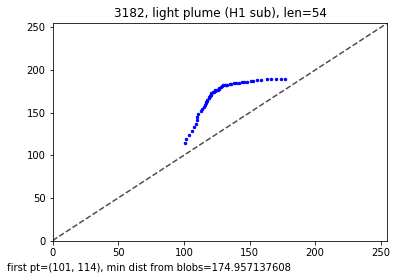

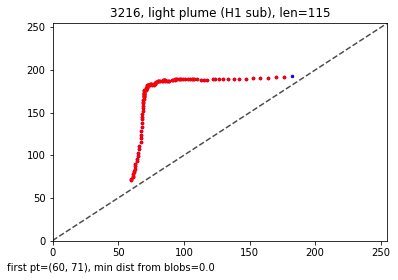

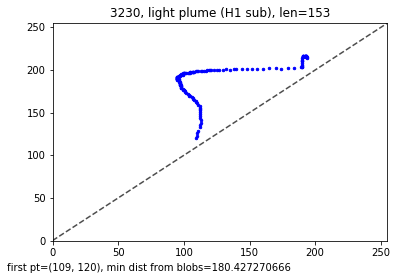

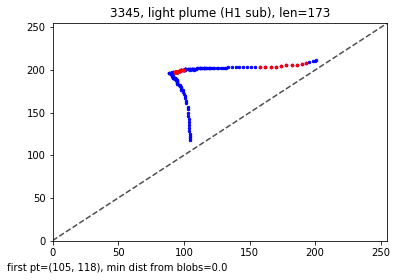

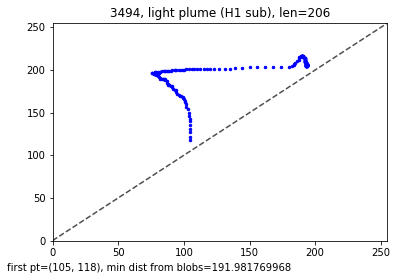

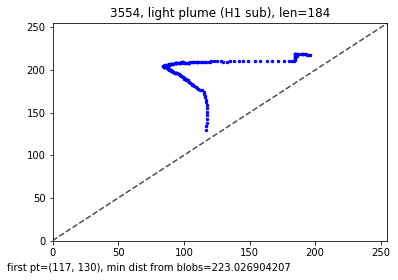

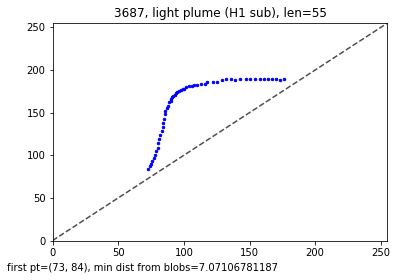

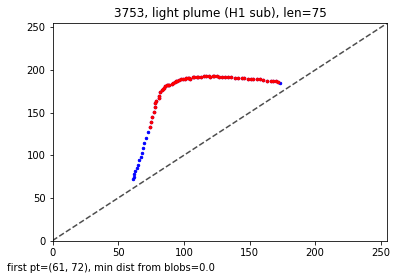

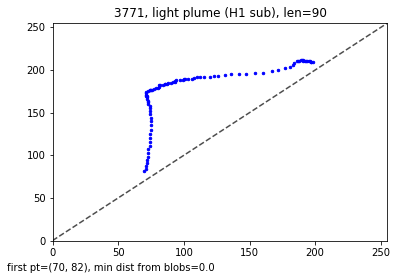

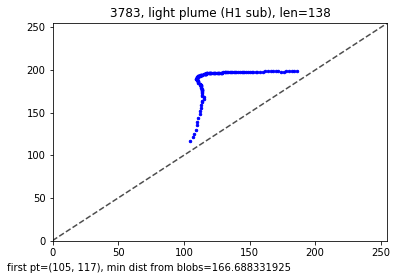

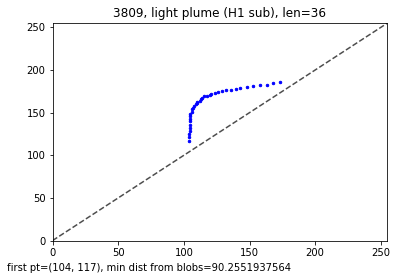

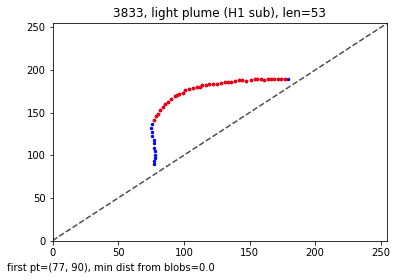

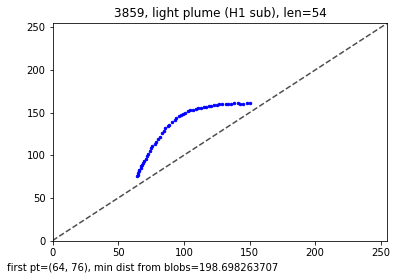

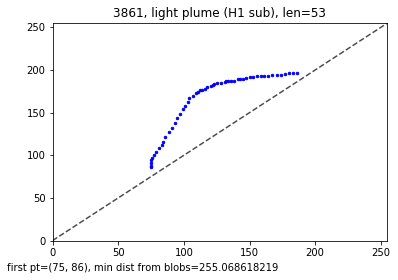

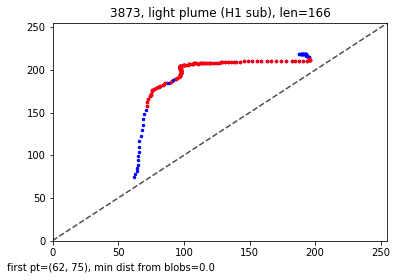

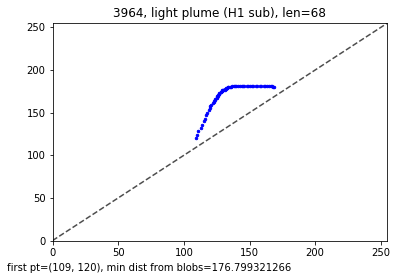

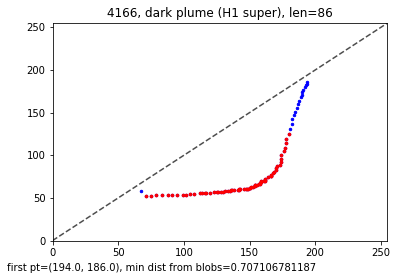

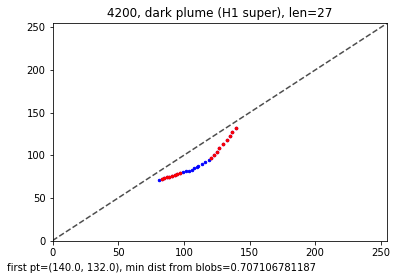

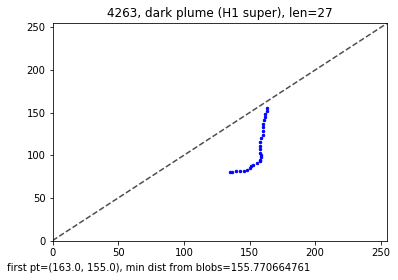

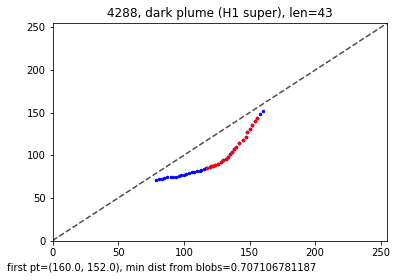

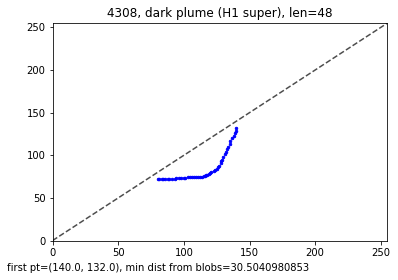

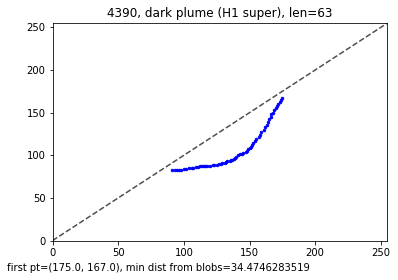

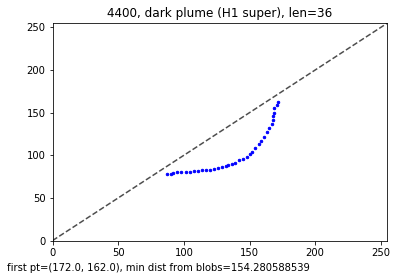

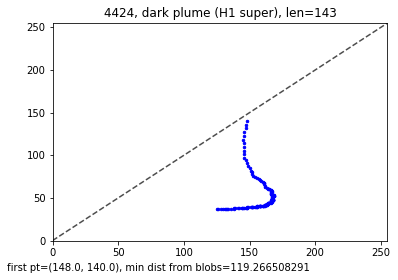

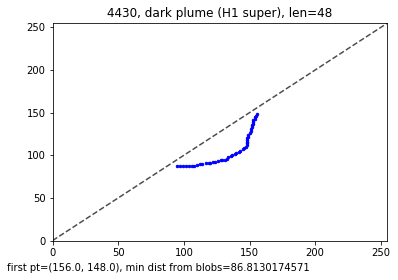

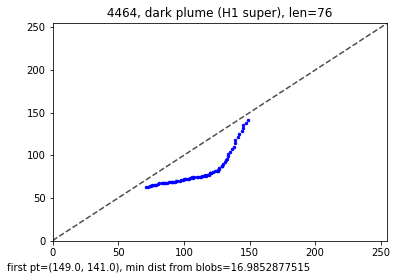

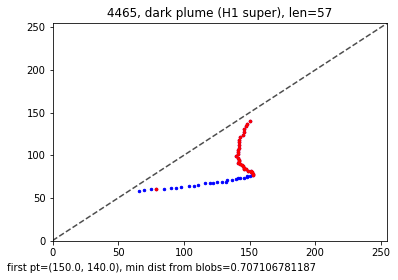

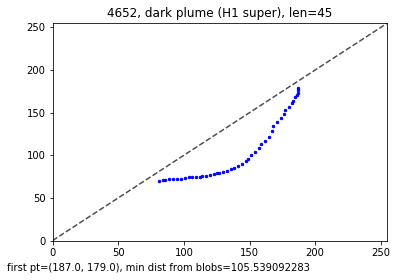

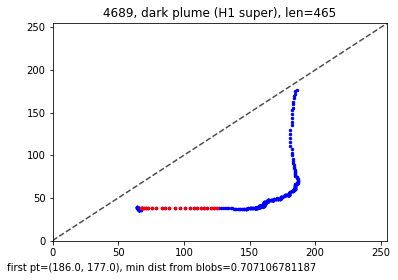

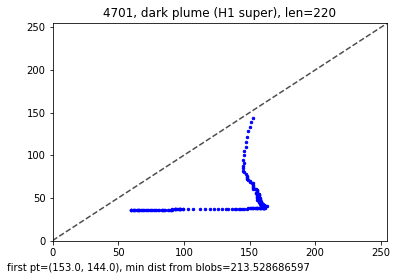

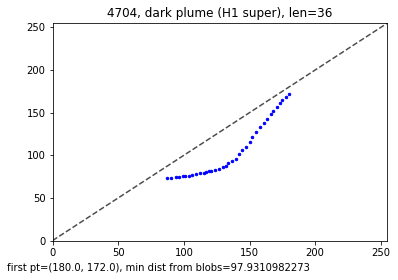

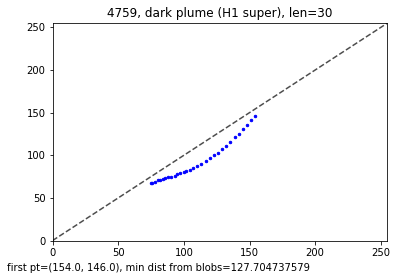

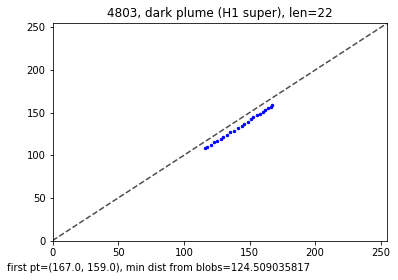

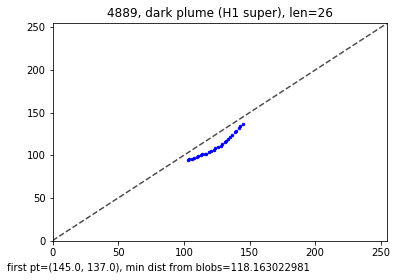

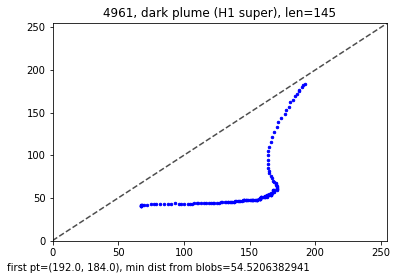

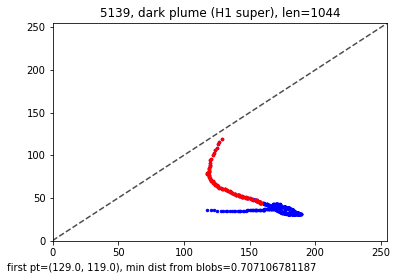

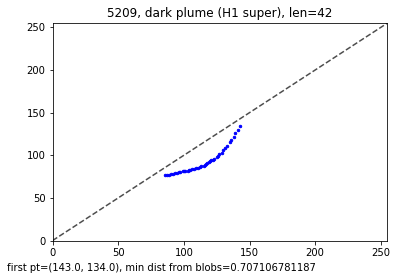

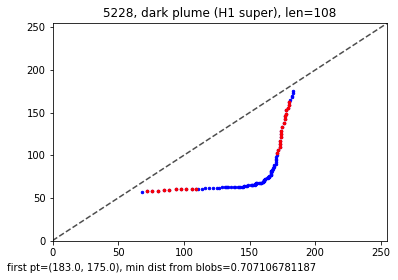

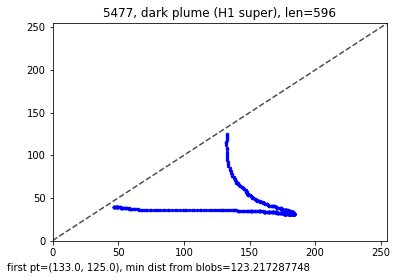

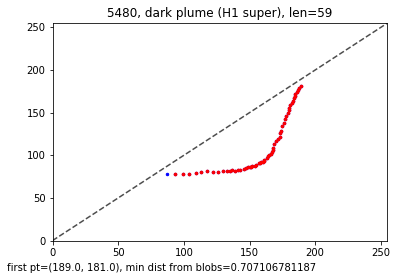

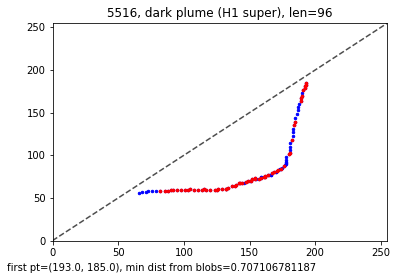

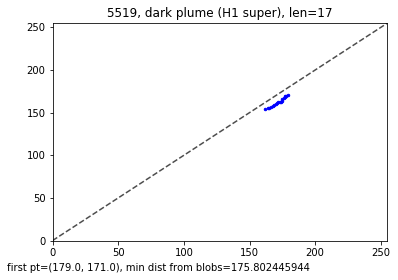

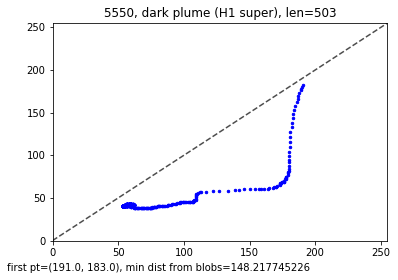

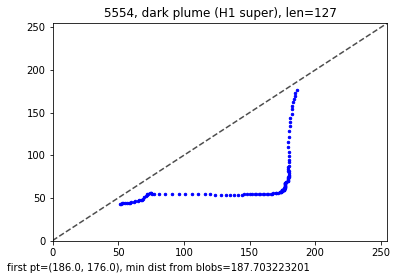

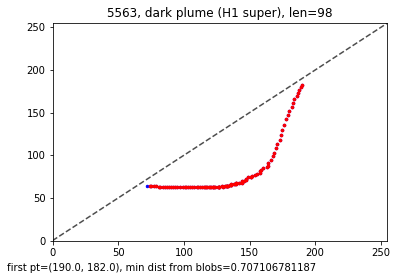

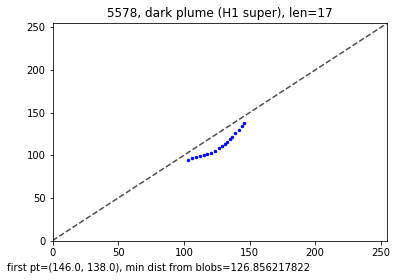

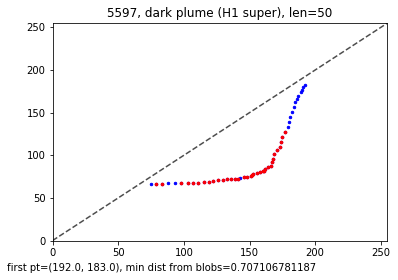

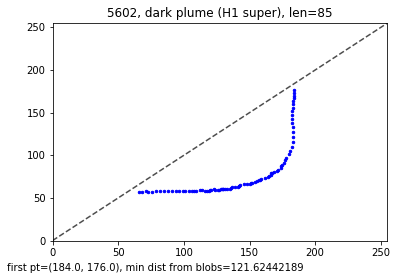

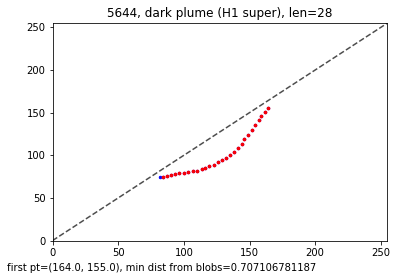

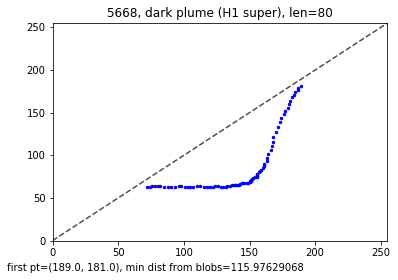

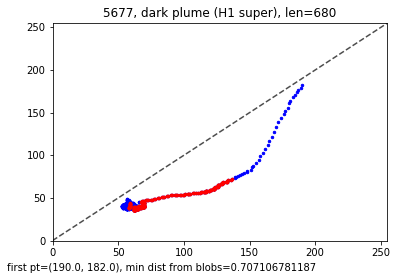

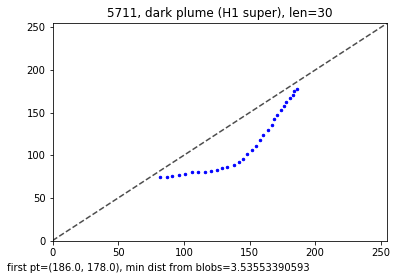

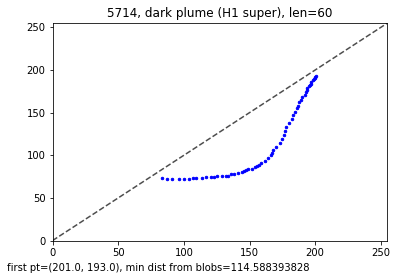

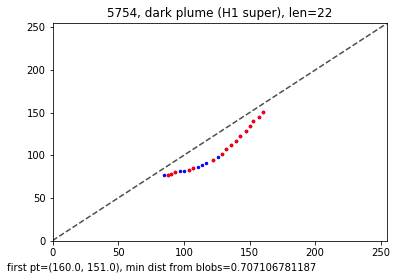

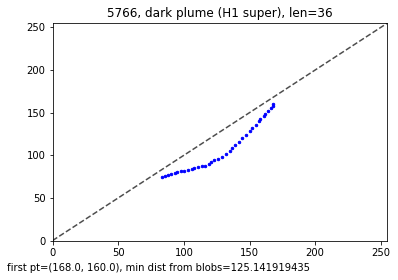

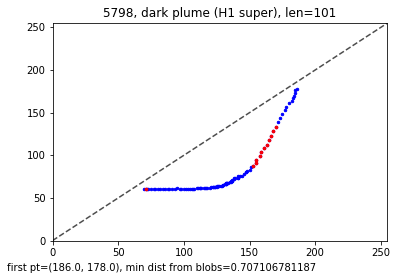

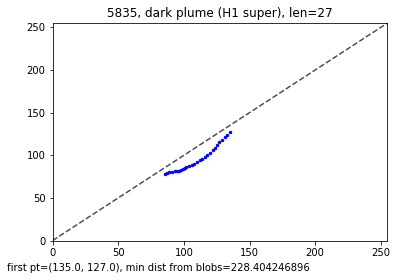

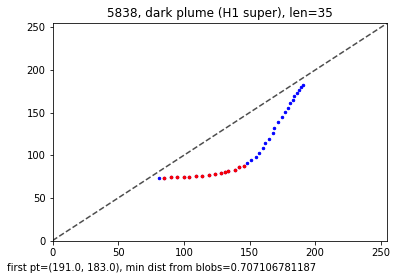

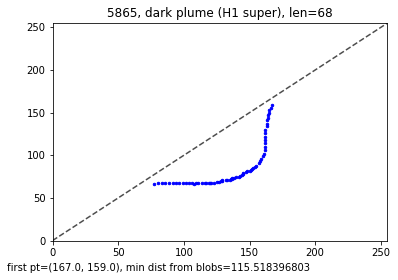

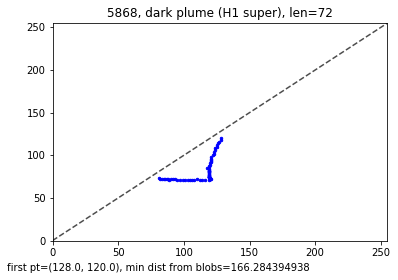

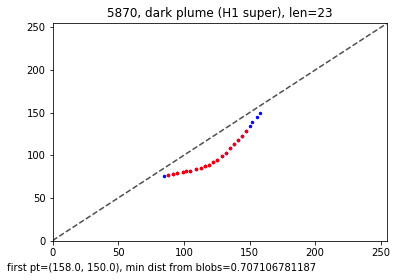

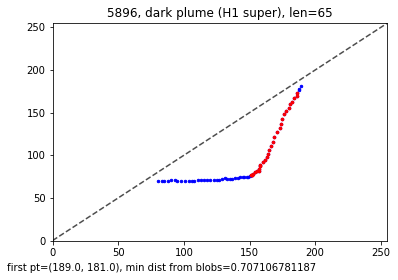

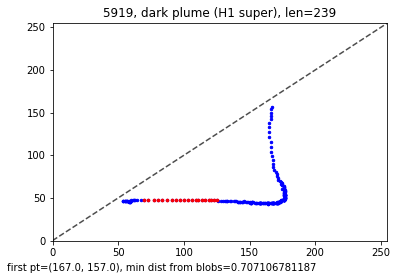

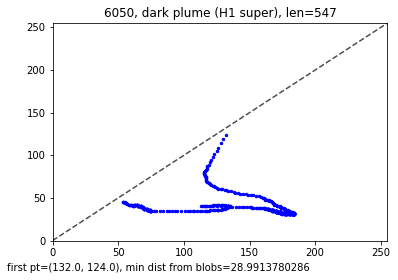

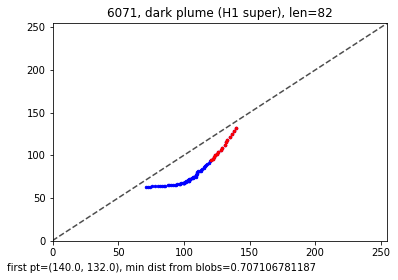

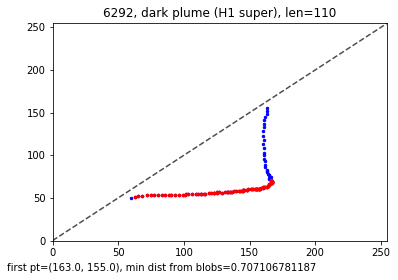

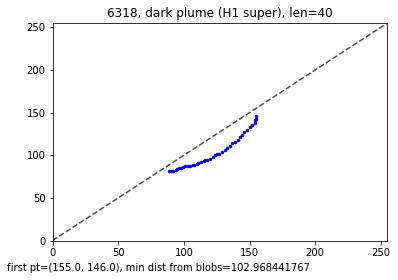

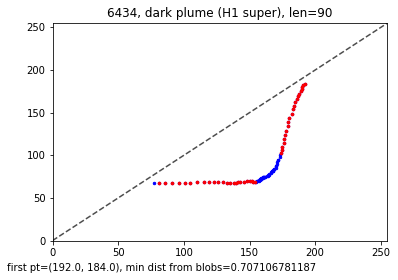

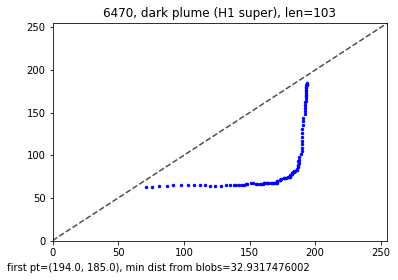

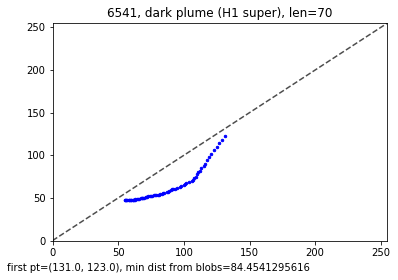

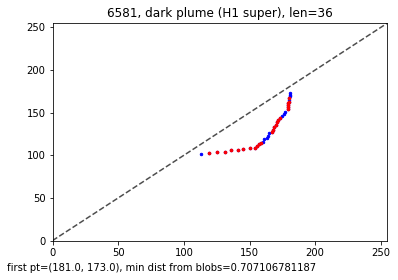

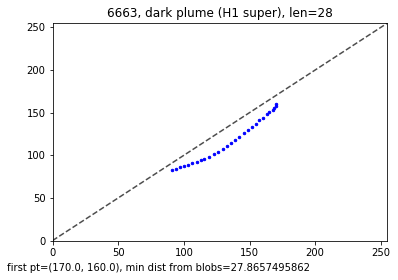

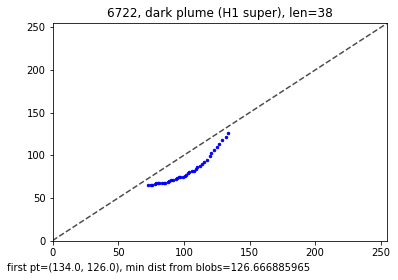

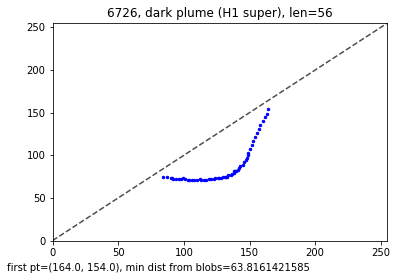

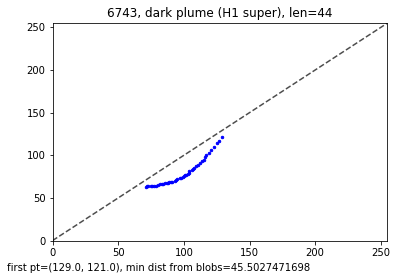

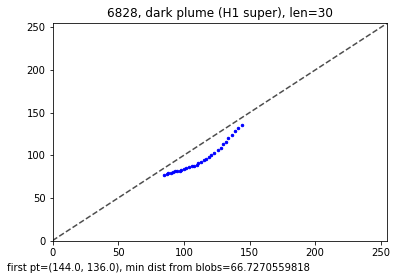

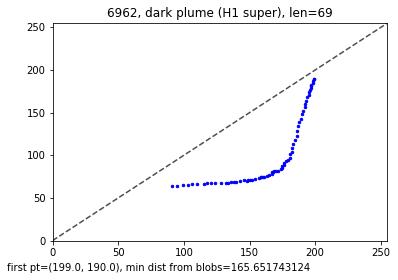

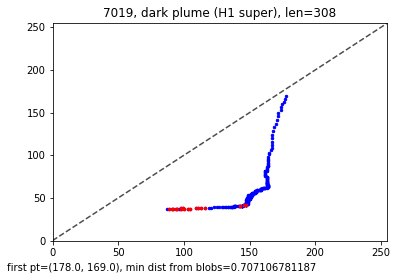

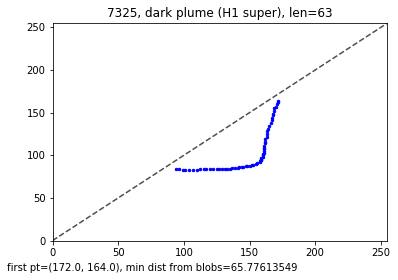

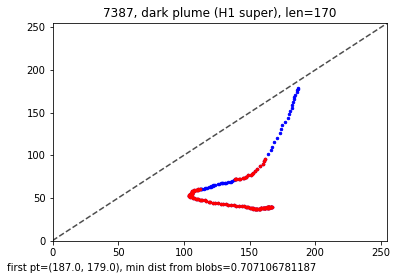

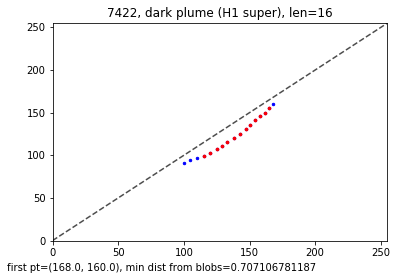

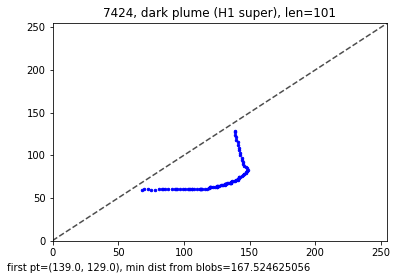

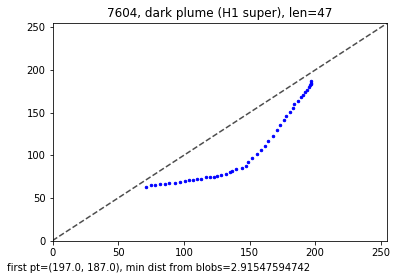

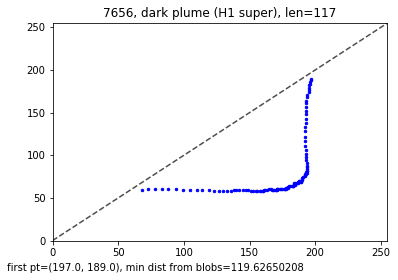

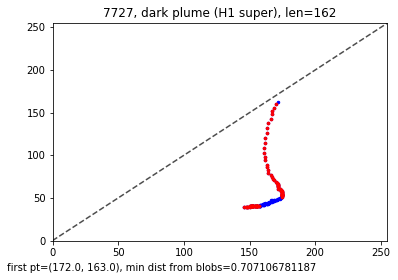

In [14]:
print('OUTPUT OF ALL PATHS SELECTED BY THE BOOLEAN FORMULA ')
for i in range(len(paths)):

    pathlen = paths[i][2] - paths[i][1]
    fldist = (paths[i][ind('birth')][0]-paths[i][ind('birth')][-1])*(paths[i][ind('birth')][0]-paths[i][ind('birth')][-1]) + (paths[i][ind('death')][0]-paths[i][ind('death')][-1])*(paths[i][ind('death')][0]-paths[i][ind('death')][-1])
    fldist = math.sqrt(fldist)
    #sat = (pathlen > 30 and (paths[i][ind('avg_p_firstpts')] <= 15 or paths[i][ind('avg_p_lastpts')] <= 15) and paths[i][ind('max_p')] > 40 and pathlen < 200) or (pathlen > 600 and paths[i][ind('max_p')] > 140) or (paths[i][ind('birth')][0] <= 50 and pathlen > 45 and fldist > 5) or (paths[i][ind('birth')][0] >= 180 and pathlen > 45 and fldist > 5)
    maxbirth = np.amax(paths[i][ind('birth')])
    mindeath = np.amin(paths[i][ind('death')])
    
    #sat = computesat(paths[i][ind('death')][0], paths[i][ind('birth')][0], paths[i][ind('death')][-1], paths[i][ind('birth')][-1], fldist, maxbirth, mindeath)
    bretc = brettscondition(paths[i][ind('dim')], pathlen, paths[i][ind('birth')], paths[i][ind('death')])
    
    if( bretc ):
        begin = paths[i][1]
        end = paths[i][2]        
        
        #plots the path which picksup the vector
        pyp.title((str)(i) + ( ', dark plume (H1 super)' if paths[i][3] == 0 else ', light plume (H1 sub)' ) + ', len=' + (str)(pathlen))
        pyp.scatter(paths[i][ind('birth')], paths[i][ind('death')], c= 'blue', s=6)
        if(paths[i][ind('dim')] == 0):  
            pyp.scatter(np.array(paths[i][ind('birth')][:pathlen])[np.equal(paths[i][ind('b_lyap')], np.zeros(pathlen))], np.array(paths[i][ind('death')][:pathlen])[np.equal(paths[i][ind('b_lyap')], np.zeros(pathlen))], c= 'red', s=7)
        if(paths[i][ind('dim')] == 1):
            pyp.scatter(np.array(paths[i][ind('birth')][:pathlen])[np.equal(paths[i][ind('d_lyap')], np.zeros(pathlen))], np.array(paths[i][ind('death')][:pathlen])[np.equal(paths[i][ind('d_lyap')], np.zeros(pathlen))], c= 'red', s=7)
            
        pyp.figtext(.02, .02, 'first pt=(' + (str)(paths[i][ind('birth')][0]) + ', ' + (str)(paths[i][ind('death')][0]) + '), min dist from blobs=' + (str)(paths[i][18]) )# + ', #points <10 dist from blobs=' + (str)(paths[i][19]))
        ax = pyp.gca()        
        ax.set_ylim([0,255])
        ax.set_xlim([0,255])
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
        pyp.show()

In [20]:
f = open("plumes.txt", "w")

#list data for all plumes found
print('DATA OF ALL PLUMES FOUND ')
for i in range(len(paths)):
    pathlen = paths[i][2] - paths[i][1]
    fldist = (paths[i][ind('birth')][0]-paths[i][ind('birth')][-1])*(paths[i][ind('birth')][0]-paths[i][ind('birth')][-1]) + (paths[i][ind('death')][0]-paths[i][ind('death')][-1])*(paths[i][ind('death')][0]-paths[i][ind('death')][-1])
    fldist = math.sqrt(fldist)
    #sat = (pathlen > 30 and (paths[i][ind('avg_p_firstpts')] <= 15 or paths[i][ind('avg_p_lastpts')] <= 15) and paths[i][ind('max_p')] > 40 and pathlen < 200) or (pathlen > 600 and paths[i][ind('max_p')] > 140) or (paths[i][ind('birth')][0] <= 50 and pathlen > 45 and fldist > 5) or (paths[i][ind('birth')][0] >= 180 and pathlen > 45 and fldist > 5)
    maxbirth = np.amax(paths[i][ind('birth')])
    mindeath = np.amin(paths[i][ind('death')])
    sat = computesat(paths[i][ind('death')][0], paths[i][ind('birth')][0], paths[i][ind('death')][-1], paths[i][ind('birth')][-1], fldist, maxbirth, mindeath)
    
    if( sat ):
        #output relevant data
        begin = paths[i][1]
        end = paths[i][2]        
        
        f.write('\nplume #' + (str)(i) + '\n')
        f.write('dark plume (H1 super)' if paths[i][3] == 0 else 'light plume (H1 sub)'+ '\n')
        f.write('birth coordinates:'+ '\n')
        f.write((str)(paths[i][ind('birth')])+ '\n')
        f.write('death coordinates:'+ '\n')
        f.write((str)(paths[i][ind('death')])+ '\n')
        
        f.write('b_x coordinates:'+ '\n')
        f.write((str)(paths[i][ind('b_x')])+ '\n')
        f.write('b_y coordinates:'+ '\n')
        f.write((str)(paths[i][ind('b_y')])+ '\n')
        
        f.write('d_x coordinates:'+ '\n')
        f.write((str)(paths[i][ind('d_x')])+ '\n')
        f.write('d_y coordinates:'+ '\n')
        f.write((str)(paths[i][ind('d_y')])+ '\n')
        
        
        begin = paths[i][1]
        end = paths[i][2]
        f.write('begin frame #:')
        f.write((str)(begin))
        f.write('end frame #:')
        f.write((str)(end))
        if(len(paths[i]) >18):
            f.write('min dist to a lyapunov blob:\n' + (str)(paths[i][18]) + '\n' )
        else:
            f.write('min dist to a lyapunov blob not computed\n' )

f.close()

DATA OF ALL PLUMES FOUND 
